In [155]:
import numpy as np
import pandas as pd
from scipy.special import polygamma
import scipy.optimize

def newton(f, J, x0, epsilon, max_iter):
    xn = x0
    for n in range(max_iter):
        fxn = f(xn)
        if np.abs(fxn).max() < epsilon:
            print('Found solution after', n, 'iterations.')
            return xn
        Dfxn = J(xn)
        try:
            delta = np.linalg.solve(Dfxn, -fxn)
            # delta = - fxn / Dfxn
        except np.linalg.LinAlgError:
            print('Jacobian is singular. No solution found.')
            return None
        xn = xn + delta
        # print(fxn)
        # print(Dfxn)
        print(xn)
        print(delta)
        print('='*70)
    print('Exceeded maximum iterations. No solution found.')
    return None

## Problem 2

In [189]:
data = '3.547 1.228 2.052 1.556 2.487 0.469 2.707 0.395 0.770 0.666 4.242 1.474 1.277 2.519 0.578 2.989 1.900 1.422 3.701 1.278 2.820 0.224 0.482 1.426 2.146 2.975 2.792 0.846 3.190 1.680 0.686 1.634 0.969 4.010 1.792 1.287 0.730 0.849 2.447 2.147'

data = list(map(lambda x: eval(x), data.split(' ')))
data = np.array(data)

n = len(data)

x_bar = data.mean()
log_bar_x = np.log(data).mean()
var = np.var(data)

alpha_hat = x_bar**2 /var
beta_hat  = var/x_bar

print(alpha_hat)
print(beta_hat)
print(x_bar)

psi = lambda x: polygamma(0,x)
trigamma = lambda x: polygamma(1,x)

2.9028968810847524
0.6234203535758195
1.8097249999999998


In [166]:
f = lambda x: np.array([psi(x[0]) - log_bar_x + np.log(x_bar) - np.log(x[0]) , x_bar - x[0]*x[1]])
Df = lambda x: np.array([[trigamma(x[0])*n, n/x[1]],
                         [n/x[1], - n * x[0] / x[1]**2 + np.sum(data) * 2 / x[1]**3 ]])

# Custom wrapper for the function to log iterations
def newton_verbose(func, x0, fprime=None, tol=1.48e-8, maxiter=50):
    def verbose_wrapper(x):
        fx = func(x)
        print(f"Iteration: x = {x}, f(x) = {fx}")
        return fx

    if fprime is not None:
        def verbose_derivative(x):
            fpx = fprime(x)
            print(f"    Derivative: f'(x) = {fpx}")
            return fpx
        return scipy.optimize.newton(verbose_wrapper, x0, fprime=verbose_derivative, tol=tol, maxiter=maxiter)
    else:
        return scipy.optimize.newton(verbose_wrapper, x0, tol=tol, maxiter=maxiter)
        
x0 = [alpha_hat, beta_hat]

# scipy.optimize.newton(f, x0=x0, maxiter=50)
x = newton_verbose(f, x0)

Iteration: x = [2.90289688 0.62342035], f(x) = [ 2.79815628e-02 -2.22044605e-16]
Iteration: x = [2.90292353 0.62343144], f(x) = [ 2.79833216e-02 -4.87951626e-05]
Iteration: x = [2.47891593 0.62342035], f(x) = [-0.00505533  0.26431835]
Iteration: x = [2.54379442 0.62343144], f(x) = [0.00075228 0.22384359]
Iteration: x = [2.53539052 0.62349273], f(x) = [1.76535516e-05 2.28927434e-01]
Iteration: x = [2.53518857 0.62073252], f(x) = [-6.31416994e-08  2.36051001e-01]
Iteration: x = [2.53518929 0.71219656], f(x) = [5.28066479e-12 4.17191214e-03]
Iteration: x = [2.53518929 0.71384216], f(x) = [0.00000000e+00 8.08119638e-09]


In [197]:
beta_se_cond = 1/np.sqrt(n/x_bar**2)

I11 = n * trigamma(x[0])
I22 = n * x[0]/x[1]**2
I21 = n / x[1]
I = np.array([[I11, I21],[I21, I22]])
sigma = np.linalg.inv(I)
print(beta_se_cond)
print(np.sqrt(sigma[0,0]))
print(np.sqrt(sigma[1,1]))

0.286142646927411
0.5338078821623577
0.16618338837738744


In [176]:
from scipy.special import gammaln  # Logarithm of the Gamma function

def log_likelihood_gamma(alpha, beta, data):
    """
    Compute the log-likelihood of the Gamma distribution.
    
    Parameters:
        alpha (float): Shape parameter (α > 0).
        beta (float): Scale parameter (β > 0).
        data (array-like): Observed data (positive values).
        
    Returns:
        float: Log-likelihood value.
    """
    if alpha <= 0 or beta <= 0:
        raise ValueError("Alpha and Beta must be greater than 0.")
    if np.any(data <= 0):
        raise ValueError("All data points must be positive.")

    n = len(data)
    term1 = -n * (alpha * np.log(beta) + gammaln(alpha))
    term2 = (alpha - 1) * np.sum(np.log(data))
    term3 = -np.sum(data) / beta

    return term1 + term2 + term3

In [179]:
l1 = log_likelihood_gamma(x[0], x[1], data)

In [180]:
l0 = log_likelihood_gamma(1, x_bar, data)

In [183]:
lamb = 2 * (l1-l0)

In [184]:
lamb

np.float64(15.287789872620692)

## Problem 3

In [185]:
0.95**0.05

0.9974386212234697

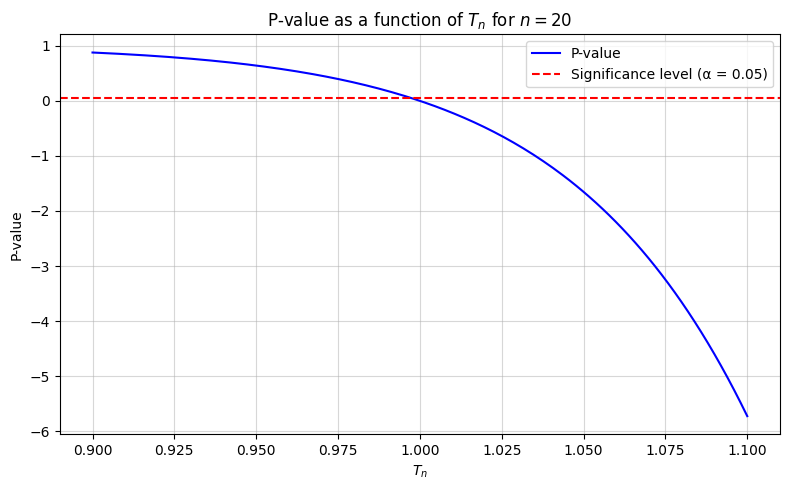

In [198]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 20  # Sample size
Tn_range = np.linspace(0.9, 1.1, 200)  # Range of Tn values

p_values = 1 - Tn_range**n

# Plot
plt.figure(figsize=(8, 5))
plt.plot(Tn_range, p_values, label="P-value", color='blue')
plt.axhline(y=0.05, color='red', linestyle='--', label="Significance level (α = 0.05)")
plt.title("P-value as a function of $T_n$ for $n=20$")
plt.xlabel("$T_n$")
plt.ylabel("P-value")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('plot_4_3_c.pdf')
plt.show()